# Gold marker segmentation with QSM

## Imports

In [1]:
import fastai
import pandas as pd
import scipy.ndimage 
from useful_functions import *
from fastMONAI.vision_all import *
from glob import glob as glob
from sklearn.model_selection import train_test_split


## Prepare data
### Locate input data

The files are 3D NIfTI images.

In [2]:
# input data
qsm_files = [x for x in sorted(glob("bids/sub-*/ses-*/extra_data/*qsm.nii*")) if '-new' not in x]
seg_files = [x for x in sorted(glob("bids/sub-*/ses-*/extra_data/*segmentation*clean.nii*")) if '-new' not in x]
t2s_files = [x for x in sorted(glob("bids/sub-*/ses-*/extra_data/*t2starmap.nii*")) if '-new' not in x]
mag_files = [x for x in sorted(glob("bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*")) if '-new' not in x]
assert(len(qsm_files) == len(seg_files))
df = pd.DataFrame({ 'qsm_files' : qsm_files, 'seg_files' : seg_files })
df

,qsm_files,seg_files
0,bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_qsm.nii,bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz
1,bids/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_qsm.nii,bids/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz
2,bids/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_qsm.nii,bids/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii
3,bids/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_qsm.nii,bids/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz
4,bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_qsm.nii,bids/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz
5,bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_qsm.nii,bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz
6,bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_qsm.nii,bids/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz
7,bids/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_qsm.nii,bids/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii
8,bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_qsm.nii,bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz
9,bids/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_qsm.nii,bids/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_segmentation_clean.nii.gz


In [3]:
train_df, test_df = train_test_split(df, test_size=2, random_state=42)
print(f"Training samples shape: {train_df.shape}")
print(f"Testing samples shape: {test_df.shape}")

Training samples shape: (11, 2)
Testing samples shape: (2, 2)


In [4]:
med_dataset = MedDataset(
    img_list=train_df.seg_files.tolist(),
    dtype=MedMask,
    max_workers=12
)
med_dataset.df.head()
#med_dataset.summary()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2
0,bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz,146,160,60,1.4,1.4,1.4,RAS+,1401551,49,NaN
1,bids/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz,146,160,60,1.4,1.4,1.4,RAS+,1401381,45,174.0
2,bids/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz,146,160,60,1.4,1.4,1.4,RAS+,1401547,53,NaN
3,bids/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii,146,160,60,1.4,1.4,1.4,RAS+,1401364,32,204.0
4,bids/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz,146,160,60,1.4,1.4,1.4,RAS+,1401575,25,NaN


In [5]:
suggested_voxelsize, requires_resampling = med_dataset.suggestion()
print(f"Suggested voxel size: {suggested_voxelsize}")
print(f"Requires resampling: {requires_resampling}")

Suggested voxel size: [1.4, 1.4, 1.4]
Requires resampling: False


In [6]:
largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)
print(f"Largest image size: {largest_imagesize}")

Largest image size: [146.0, 160.0, 72.0]


In [7]:
import numpy as np
from skimage.measure import label, regionprops

def get_center_slices(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    center_slices = [[round(coord) for coord in region.centroid] for region in regions]
    return center_slices

In [8]:
class SetVrange(DisplayedTransform):
    def __init__(self, vmin, vmax):
        self.vmin = vmin
        self.vmax = vmax

    def encodes(self, o:MedImage):
        o[o > self.vmax] = 0
        o[o < self.vmin] = 0
        return o
    
def show_images(x, y, figsize=None):
    n_samples = x.shape[0]
    n_masks = y.shape[0]
    assert(n_samples == n_masks)

    mask = y.cpu().numpy()
    qsm = x.cpu().numpy()

    max_sources = 0
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] != 0, dtype=int))
        num_sources = len(center_slices)
        max_sources = max(num_sources, max_sources)

    figsize = figsize or (10, 2 + 2 * n_samples)
    fig, axes = plt.subplots(ncols=max_sources, nrows=n_samples, figsize=figsize, squeeze=False)
    for ax in axes.flat:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] != 0, dtype=int))
        num_sources = len(center_slices)

        for j in range(num_sources):
            axes[i,j].imshow(qsm[i][0][center_slices[j][0],:,:], cmap='gray', vmin=-5, vmax=+5, interpolation='nearest') 
            axes[i,j].imshow(mask[i][0][center_slices[j][0],:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(mask[i][0][center_slices[j][0],:,:] != 0, dtype=int) * 0.6)

    plt.show()
    plt.close()
    
@typedispatch
def show_batch(x:MedImage, y:MedMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    show_images(x, y)
    

Training examples: 9
Validation examples: 2


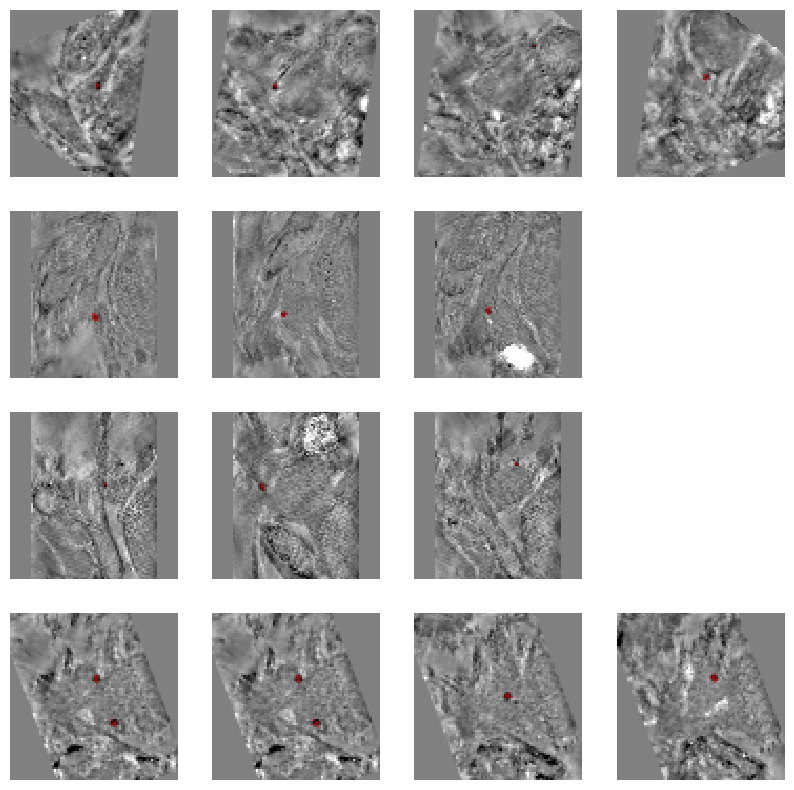

In [9]:
dblock = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(),#seed=42),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        RandomFlip(axes=("LR",)),
        RandomFlip(axes=("AP",)),
        RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls = DataLoaders.from_dblock(dblock, train_df, bs=4)
print(f"Training examples: {len(dls.train_ds.items)}")
print(f"Validation examples: {len(dls.valid_ds.items)}")
dls.show_batch(anatomical_plane=2)

In [10]:
from monai.losses import DiceCELoss
from monai.networks.nets import UNet

In [13]:
model = UNet(
    spatial_dims=3,
    in_channels=1,  # qsm
    out_channels=3, # background, marker, calcification
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

In [14]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

In [15]:
class MarkersIdentified(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn):
        pred = learn.pred.argmax(dim=1).cpu().numpy()
        targ = learn.y.cpu().numpy()
        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i])
            _, targ_nlabels = scipy.ndimage.label(targ[i])
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] != 0), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.overlap_count) / max(1., float(self.targ_marker_count))

In [16]:
class SuperfluousMarkers(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn):
        pred = learn.pred.argmax(dim=1).cpu().numpy()
        targ = learn.y.cpu().numpy()
        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i])
            _, targ_nlabels = scipy.ndimage.label(targ[i])
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] != 0), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.pred_marker_count - self.overlap_count) / max(1., float(self.pred_marker_count))

In [17]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=[multi_dice_score])#, MarkersIdentified(), SuperfluousMarkers()])#.to_fp16()

In [18]:
#learn.lr_find()

In [19]:
lr = 0.003

In [20]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,2.035859,2.036543,"tensor([0.0001, 0.0011])",00:05
1,2.023344,2.006049,"tensor([0.0001, 0.0011])",00:06
2,2.007896,2.019402,"tensor([0.0001, 0.0011])",00:05
3,2.002506,1.966508,"tensor([9.6338e-05, 1.1310e-03])",00:05
4,1.985173,1.901088,"tensor([0.0001, 0.0014])",00:05
5,1.962710,1.914407,"tensor([0.0001, 0.0013])",00:05
6,1.946697,1.836643,"tensor([0.0001, 0.0015])",00:04
7,1.927106,1.778991,"tensor([0.0001, 0.0016])",00:04
8,1.906354,1.799242,"tensor([0.0001, 0.0015])",00:05
9,1.891610,1.739487,"tensor([0.0001, 0.0015])",00:05


In [21]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.681923,0.682147,"tensor([0., 0.])",00:04
1,0.681436,0.682158,"tensor([0., 0.])",00:04
2,0.681312,0.681420,"tensor([0., 0.])",00:04
3,0.681063,0.680676,"tensor([0., 0.])",00:04
4,0.680742,0.681026,"tensor([0., 0.])",00:04
5,0.680615,0.680332,"tensor([0., 0.])",00:04
6,0.680394,0.679686,"tensor([0., 0.])",00:04
7,0.680153,0.679997,"tensor([0., 0.])",00:04
8,0.680011,0.679402,"tensor([0., 0.])",00:04
9,0.679794,0.678701,"tensor([0., 0.])",00:04


In [22]:
learn.fit_flat_cos(100, lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.619082,0.647345,"tensor([0.0323, 0.0290])",00:04
1,0.618116,0.639335,"tensor([0.0303, 0.0571])",00:04
2,0.617215,0.631878,"tensor([0.0859, 0.0751])",00:04
3,0.617784,0.636445,"tensor([0.0606, 0.0478])",00:04
4,0.615918,0.626681,"tensor([0.0862, 0.1014])",00:04
5,0.613536,0.612531,"tensor([0.1255, 0.2948])",00:04
6,0.610053,0.630268,"tensor([0.1160, 0.0478])",00:04
7,0.608442,0.612225,"tensor([0.2016, 0.0922])",00:04
8,0.606920,0.640310,"tensor([0.0286, 0.0194])",00:04
9,0.605206,0.604371,"tensor([0.2234, 0.1834])",00:04


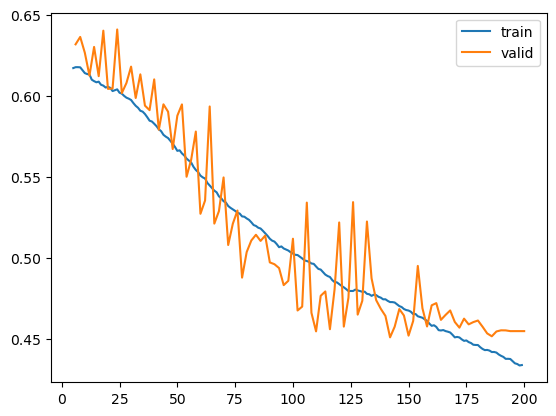

In [23]:
learn.recorder.plot_loss()

In [24]:
learn.save('prostate-model')

Path('models/prostate-model.pth')

In [25]:
dblock_test = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(seed=42),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        #RandomFlip(axes=("LR",)),
        #RandomFlip(axes=("AP",)),
        #RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls_test = DataLoaders.from_dblock(dblock_test, test_df, bs=len(test_df))

In [26]:
@typedispatch
def show_results(x:MedImage, y:MedMask, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    outs = torch.stack([outs[i][0] for i in range(len(outs))], dim=0)
    #samples_x = torch.stack([samples[i][0][0] for i in range(len(samples))], dim=0).unsqueeze(1)
    #samples_y = torch.stack([samples[i][1] for i in range(len(samples))], dim=0)
    #show_images(x, y)
    #show_images(samples_x, samples_y)
    show_images(x, y)
    show_images(x, outs)

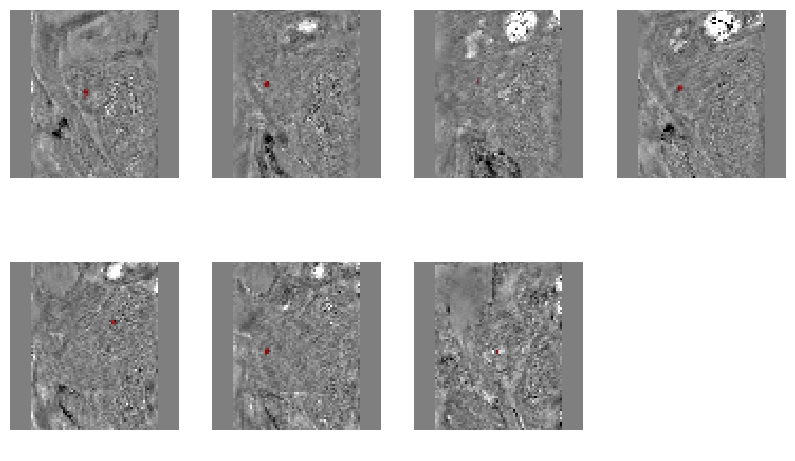

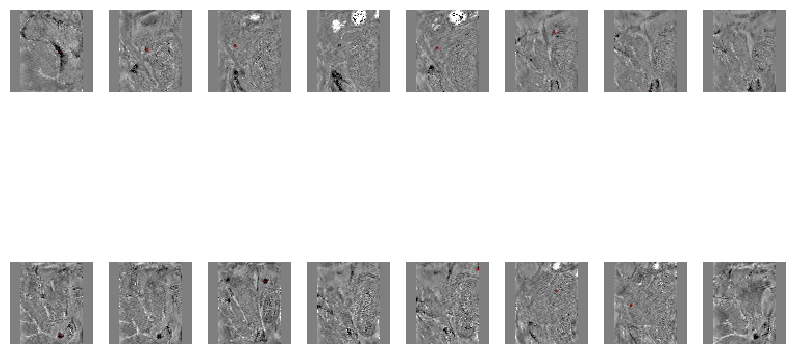

In [27]:
learn.show_results(anatomical_plane=0, dl=dls_test, shuffle=True)

In [29]:
loss, *metrics = learn.validate(dl=dls_test[0])
print(f"Dice score: {metrics[0]}")# Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")

Dice score: tensor([0.6250, 0.0000])
